1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    

3. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

<font color='blue'>**Load the data**</font>

In [ ]:
import os
if 'ita.txt' not in os.listdir():
    !wget http://www.manythings.org/anki/ita-eng.zip
    !unzip ita-eng.zip

--2020-09-21 08:07:31--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7468237 (7.1M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.12M  4.54MB/s    in 1.6s    

2020-09-21 08:07:32 (4.54 MB/s) - ‘ita-eng.zip’ saved [7468237/7468237]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
if 'glove.6B.100d.txt' not in os.listdir():
    !wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2020-09-21 08:07:33--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2020-09-21 08:07:33--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucebcc15bdee938723f0111297ad.dl.dropboxusercontent.com/cd/0/inline/A_w1Jfq6fuy_M0Bq1JhSrxtjtv8ojsPfiuRFyxIupXZ7OUkilF42HuNQJbAVMgYqiooj8O-oQ8F-Xyl0VAByAL4bEVH5rvK-jNOFJj1rEcAORHVJcrpOJRLJzBU5dvbEE24/file# [following]
--2020-09-21 08:07:33--  https://ucebcc15bdee938723f0111297ad.dl.dropboxusercontent.com/cd/0/inline/A_w1Jfq6fuy_M0Bq1JhSrxtjtv8ojsPfiuRFyxIupXZ7OUkilF42HuNQJbAVMgYqiooj8O-oQ8F-Xyl0VAByAL4bEVH5rvK-jNO

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import save_model, load_model
tf.config.run_functions_eagerly(True)
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

from tqdm.notebook import tqdm

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15354251413126074276
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16090073807451913920
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1766355180172356503
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4373390264796627401
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
with open('ita.txt', 'r', encoding="utf8") as f:
    eng=[]
    ita=[]
    for i in f.readlines():
        eng.append(i.split("\t")[0])
        ita.append(i.split("\t")[1])
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(341554, 2)


,english,italian
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


<font color='blue'>**Preprocess data**</font>

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", text) # puts a space between punctuations and words
    #text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    #text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", text) # puts a space between punctuations and words
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi .,ciao
1,run !,corri
2,run !,corra
3,run !,correte
4,who ?,chi


In [ ]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
print('-'*15)
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
print('-'*15)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
---------------
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
---------------
99.1 12.0
99.2 12.0
99.3 12.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 20.0
100 92.0


In [ ]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
print('-'*15)
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
print('-'*15)
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 2.0
10 5.0
20 5.0
30 6.0
40 6.0
50 7.0
60 7.0
70 8.0
80 8.0
90 10.0
100 111.0
---------------
90 10.0
91 10.0
92 10.0
93 10.0
94 10.0
95 11.0
96 11.0
97 11.0
98 12.0
99 13.0
100 111.0
---------------
99.1 14.0
99.2 14.0
99.3 14.0
99.4 15.0
99.5 15.0
99.6 16.0
99.7 17.0
99.8 18.0
99.9 22.0
100 111.0


In [ ]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentence add a token <end> so that we will have <end> in tokenizer
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi .,hi . <end>
1,corri,<start> run !,run ! <end>
2,corra,<start> run !,run ! <end>
3,correte,<start> run !,run ! <end>
4,chi,<start> who ?,who ? <end>


### **Train-Test split**

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2)
print(train.shape, validation.shape)

# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(272866, 3) (68217, 3)


In [ ]:
train.head()

,italian,english_inp,english_out
280488,la mappa mi aiutò a orientarmi,<start> the map helped me to orient myself . ...,the map helped me to orient myself . <end> <end>
140206,che stai facendo tom,"<start> what are you doing , tom ?","what are you doing , tom ? <end>"
55397,siete liberi di andare,<start> you are free to go .,you are free to go . <end>
270174,voglio imparare a suonare il flauto,<start> i want to learn to play the flute .,i want to learn to play the flute . <end>
210767,è tutto quello che vuoi sapere,<start> is that all you want to know ?,is that all you want to know ? <end>


In [ ]:
validation.head()

,italian,english_inp,english_out
10538,siamo adulti,<start> we are adults .,we are adults . <end>
309181,io penso che il vostro inglese sia migliorato ...,<start> i think your english has improved a lo...,i think your english has improved a lot . <end>
244856,tutti gli uomini sono uguali secondo la legge,<start> all men are equal under the law .,all men are equal under the law . <end>
10754,mi auguri buona fortuna,<start> wish me luck .,wish me luck . <end>
47555,io dormii fino allalba,<start> i slept till dawn .,i slept till dawn . <end>


### **Tokenizer**

In [ ]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
#tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')  # Notice this does not have '<' and '>' characters in the filter
tknizer_eng = Tokenizer(filters='!"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')  # Notice this does not have '<' and '>' characters in the filter. Also removed punctuations like comma, full stop and question mark from filter
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [ ]:
# import re
# from tensorflow.keras.preprocessing.text import Tokenizer
# tknizer_abc = Tokenizer(filters='!"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
# abc_input = ['chintan , # dave . ', u"machine learning's the future? "]
# for a in range(len(abc_input)):
#     abc_input[a] = re.sub(r"([\w/'+$\s-]+|[^\w/'+$\s-]+)\s*", r"\1 ", abc_input[a])
# print(abc_input)
# tknizer_abc.fit_on_texts(abc_input)
# tknizer_abc.word_index.keys()

In [ ]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print(vocab_size_ita)

12602
26134


### **Embeddings for English sentences**

In [ ]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(12603, 100)

In [ ]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10004)

# Machine Translation Using Attention Mechanism

* To implement an Encoder and Decoder architecture with attention
* In Global attention, there are 3 types of scoring functions.
 I have created 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 implemnted "dot" score function
    * In model 2 implemnted "general" score function
    * In model 3 implemnted "concat" score function.<br>

* Resources:
    a. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    b. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    c. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

## <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.enc_units= lstm_size
        self.lstm_output=0
        self.lstm_state_h=0
        self.lstm_state_c=0

        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True )
        self.lstm = LSTM(lstm_size, return_state=True, return_sequences=True )


    def call(self, input_sequence, states):
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        input_embedd = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(input_embedd, initial_state=states)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c
    
    def initialize_states(self, batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        int_state_h = tf.zeros((batch_size, self.enc_units) )
        int_state_c = tf.zeros((batch_size, self.enc_units) )
        return int_state_h, int_state_c

<font color='blue'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
    '''
        Class that calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, scoring_function, att_units):
        super().__init__()
        self.lstm_size_e = att_units
        self.lstm_size_d = att_units
        self.scoring_function = scoring_function
 
        # Please go through the reference notebook and research paper to complete the scoring functions
        if self.scoring_function=='dot':
            # Intialize variables needed for Dot score function here
            pass
        if self.scoring_function == 'general':
            # Intialize variables needed for General score function here
            pass
        elif self.scoring_function == 'concat':
            # Intialize variables needed for Concat score function here
            pass
 
 
    def build(self, input_shape):
        if self.scoring_function == 'general':
            self.w_general = self.add_weight(shape=(self.lstm_size_e, self.lstm_size_d), initializer='random_normal', trainable=True, name='w_gen')
        elif self.scoring_function == 'concat':
            k=128
            self.w_concat_e = self.add_weight(shape=(self.lstm_size_e, k), initializer='random_normal', trainable=True, name='w_concat_1') # To be multiplied with encoder
            self.w_concat_d = self.add_weight(shape=(self.lstm_size_d, k), initializer='random_normal', trainable=True, name='w_concat_2') # To be multiplied with decoder
            self.w_v = self.add_weight(shape=(k, 1), initializer='random_normal', trainable=True, name='w_concat_v') # To be finally multiplied with tanh
 
 
    def call(self, decoder_hidden_state, encoder_output):
        '''
            Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
            * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
            Multiply the score function with your encoder_outputs to get the context vector.
            Function returns context vector and attention weights(softmax - scores)
        '''
 
        if self.scoring_function == 'dot':
            # Implement Dot score function here
            # encoder_output = [batch_size, input_length, att_units]
            # decoder_hidden_state = [batch_size, att_units]
 
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=2) # [batch_size, att_units, 1]
 
            sim = tf.matmul(encoder_output, decoder_hidden_state) # Similarity values
            # Now we have to pass this sim values to a softmax layer. As a result we will get the alpha values.
            
            sim = tf.squeeze(sim, axis=2)   # [batch_size,input_length]
            alphas = Dense(encoder_output.shape[1], activation='softmax')(sim) # encoder_output.shape[1] is input_seq_length i.e. the num of enc hidden states
            alphas = tf.expand_dims(alphas, axis=2)
            # Now we have to multiply these alphas values to the all the encoder timesteps to get the context vectors
 
            encoder_output = tf.transpose(encoder_output, perm=[0,2,1])
            context_vectors = tf.matmul(encoder_output, alphas) # [batch_size, att_units, 1]
            context_vectors = tf.squeeze(context_vectors, axis=2)   # [batch_size, att_units]
            return context_vectors, alphas
            """encoder_output shape= (16, 10, 32)
            decoder_hidden shape= (16, 32, 1)
            sim shape= (16, 10)
            alphas shape= (16, 10, 1)
            context vecotr shape= (16, 32)"""
        elif self.scoring_function == 'general':
            # Implement General score function here
            # encoder_output = [batch_size, input_length, att_units]
            # decoder_hidden_state = [batch_size, att_units]
            
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=2)
            
            # self.w_general = [enc_att_units, dec_att_units]
            sim = tf.matmul(tf.matmul(encoder_output, self.w_general), decoder_hidden_state)
            sim = tf.squeeze(sim, axis=2)
 
            alphas = Dense(encoder_output.shape[1], activation='softmax')(sim)
            alphas = tf.expand_dims(alphas, axis=2)
            # Now we have to multiply these alphas values to the all the encoder timesteps to get the context vectors
 
            encoder_output = tf.transpose(encoder_output, perm=[0,2,1])
            context_vectors = tf.matmul(encoder_output, alphas)
            context_vectors = tf.squeeze(context_vectors, axis=2)
            return context_vectors, alphas
        elif self.scoring_function == 'concat':
            # Implement General score function here
            # encoder_output = [batch_size, input_length, att_units]
            # decoder_hidden_state = [batch_size, att_units]
            
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=1)
            
            # self.w_concat_e = [enc_att_units, k]
            # self.w_concat_d = [dec_att_units, k]
            # self.w_v = [k,1]
            mat_mul_1 = tf.matmul(encoder_output, self.w_concat_e)
            mat_mul_2 = tf.matmul(decoder_hidden_state, self.w_concat_d)
            mat_mul_added = mat_mul_1 + mat_mul_2
            tanh_ = tf.math.tanh(mat_mul_added)
            sim = tf.matmul(tanh_, self.w_v)
            sim = tf.squeeze(sim, axis=2)
 
            alphas = Dense(encoder_output.shape[1], activation='softmax')(sim)
            alphas = tf.expand_dims(alphas, axis=2)
            # Now we have to multiply these alphas values to the all the encoder timesteps to get the context vectors
            
            encoder_output = tf.transpose(encoder_output, perm=[0,2,1])
            context_vectors = tf.matmul(encoder_output, alphas)
            context_vectors = tf.squeeze(context_vectors, axis=2)
            return context_vectors, alphas
            """encoder_output shape= (16, 10, 32)
            decoder_hidden shape= (16, 1, 32)
            mat mul added shape= (16, 10, 32)
            tanh_ shape= (16, 10, 32)
            sim shape= (16, 10)
            alphas shape= (16, 10, 1)
            context vecotr shape= (16, 32)"""

<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_size, input_length, dec_units ,score_fun ,att_units):
        super().__init__()
        """self.att_units = att_units
        self.score_fun = score_fun
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_size
        self.dec_units = dec_units
        self.input_length = input_length"""
        
        # Initialize decoder embedding layer, LSTM and any other objects needed
        #, weights=[embedding_matrix]
        self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length, mask_zero=True, weights=[embedding_matrix], trainable=False)
        self.lstm = LSTM(dec_units, return_sequences=True, return_state=True )
        self.attention = Attention(score_fun, att_units)
        #self.dense_softmax = Dense(out_vocab_size, activation='softmax' )  # DO NOT DO SOFTMAX HERE!!
        self.dense = Dense(out_vocab_size)
     
    
    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
            One step decoder mechanisim step by step:
            A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
            B. Using the encoder_output and decoder hidden state, compute the context vector.
            C. Concat the context vector with the step A output
            D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
            E. Pass the decoder output to dense layer(vocab size) and store the result into output.
            F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        target_embedd = self.embedding(input_to_decoder)    # [batch_size, 1, embedding_dim]. Here the 1 is the timestep, because remember this is 'one step decoder'
        
        # Concatenate context vector and embedding output
        context_vector_ = tf.expand_dims(context_vector, axis=1)    # [batch_size, 1, embedding_dim]
        concate = tf.concat([target_embedd, context_vector_], axis=-1) 
        lstm_output, state_h_out, state_c_out  = self.lstm(concate, initial_state=[state_h, state_c])

        # Pass the lstm_output to a softmax layer
        lstm_output = tf.squeeze(lstm_output, axis=1)
        dense_output = self.dense(lstm_output)
        return dense_output, state_h_out, state_c_out, attention_weights, context_vector
        """context_vector shape= (32, 16)
        input_to_decoder= (32, 1)
        embedd shape= (32, 1, 12)
        concate shape= (32, 1, 28)
        lstm_output shape= (32, 1, 16)
        lstm_output to Dense shape= (32, 16)
        state_h_out shape= (32, 16)
        state_c_out shape= (32, 16)"""

<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()

        self.input_length = input_length
        """self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units"""

        self.one_step_decoder = One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units)


    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        
        # input_to_decoder = [batch_size, input_seq_length]
        all_outputs = tf.TensorArray(dtype='float32', size=self.input_length)
        for timestep in range(self.input_length):
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step_decoder(input_to_decoder[:, timestep:timestep+1], encoder_output, decoder_hidden_state, decoder_cell_state)
            # append the output to the all_outputs and at the end return it.
            all_outputs = all_outputs.write(timestep, output)
        # each output is of shape [batch_size, out_vocab_size]
        all_outputs = tf.transpose(all_outputs.stack(), perm=[1,0,2])
        return all_outputs

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
GLOBAL_BATCH_SIZE = 1024

In [ ]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, vocab_size_ita, vocab_size_eng, encoder_inputs_length, decoder_inputs_length, embedding_dim, score_fun, att_units):
        super().__init__()
        """self.score_fun = score_fun
        self.att_units = att_units
        self.embedding_dim = embedding_dim
        self.encoder_inputs_length = encoder_inputs_length
        self.decoder_inputs_length = decoder_inputs_length

        self.vocab_size_ita = vocab_size_ita
        self.vocab_size_eng = vocab_size_eng"""

        #Intialize objects from encoder decoder
        self.encoder = Encoder(inp_vocab_size=vocab_size_ita+1, embedding_size=embedding_dim, lstm_size=att_units, input_length=encoder_inputs_length)
        self.decoder = Decoder(out_vocab_size=vocab_size_eng+1, embedding_dim=embedding_dim, input_length=decoder_inputs_length, dec_units=att_units, score_fun=score_fun, att_units=att_units)


    def call(self, data):
        # Intialize encoder states, Pass the encoder_sequence to the embedding layer
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        # return the decoder output
        input_sequence, input_to_decoder = data[0], data[1]
        # input_sequence = [batch_size, input_length]
        initial_state=self.encoder.initialize_states(batch_size=GLOBAL_BATCH_SIZE)
        encoder_output, enc_state_h, enc_state_c = self.encoder(input_sequence, initial_state)
        all_outputs = self.decoder(input_to_decoder, encoder_output, enc_state_h, enc_state_c)
        # all_outputs = [batch_size, input_length, out_vocab_size]
        return all_outputs

<font color='blue'>**Custom loss function**</font>

In [ ]:
# Custom loss function that will not consider the loss for padded zeros
# Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# Below the pred is also called logits
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

In [ ]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post', truncating='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post', truncating='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post', truncating='pre')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq
        
    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)


class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))

    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 20)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 20)

train_dataloader = Dataloader(train_dataset, batch_size=GLOBAL_BATCH_SIZE)
test_dataloader = Dataloader(test_dataset, batch_size=GLOBAL_BATCH_SIZE)

print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print(test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)
(1024, 20) (1024, 20) (1024, 20)


Implement dot function here.

In [ ]:
from tensorflow.keras.callbacks import Callback
import datetime
%load_ext tensorboard

log_dir="/content/drive/My Drive/Colab Notebooks/NLP Attention Mechanism/logs/dot/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# https://stackoverflow.com/a/42963385/7697658
lrschedule_cond_1 = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.50)

In [ ]:
train.shape

(272866, 3)

In [ ]:
# Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model_attention = encoder_decoder(vocab_size_ita, vocab_size_eng, encoder_inputs_length=20, decoder_inputs_length=20, embedding_dim=100, score_fun='dot', att_units=256)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_attention.compile(optimizer=opt, loss=loss_function)
train_steps=train.shape[0]//GLOBAL_BATCH_SIZE
valid_steps=validation.shape[0]//GLOBAL_BATCH_SIZE
model_attention.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=valid_steps, callbacks=[lrschedule_cond_1, tensorboard_callback])
model_attention.summary()

#save_model_path = "/content/drive/My Drive/Colab Notebooks/NLP Attention Mechanism/New Attention Mech/Model_Best_Dot/BEST_MODEL_ED.h5"
#model_attention.save_weights(save_model_path, save_format='tf')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
  1/266 [..............................] - ETA: 0s - loss: 3.7225WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
266/266 [==============================] - 194s 731ms/step - loss: 1.4565 - val_loss: 0.9742
Epoch 2/10
266/266 [==============================] - 194s 728ms/step - loss: 0.7080 - val_loss: 0.4489
Epoch 3/10
266/266 [==============================] - 192s 720ms/step - loss: 0.3728 - val_loss: 0.2589
Epoch 4/10
266/266 [==============================] - 192s 723ms/step - loss: 0.2416 - val_loss: 0.1791
Epoch 5/10
266/266 [==============================] - 194s 730ms/step - loss: 0.1795 - val_loss: 0.1379
Epoch 6/10
266/266 [==============================] - 193s 725ms/step - loss: 0.1435 - val_loss: 0.1138
Epoch 7/10
266/266 [=============

## <font color='blue'>**Inference**</font>

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence, model_ed, tknizer_ita, tknizer_eng):
    '''
        A. Given input sentence, convert the sentence into integers using tokenizer used earlier
        B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
        C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
        D. till we reach max_length of decoder or till the model predicted word <end>:
                predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
                Save the attention weights
                And get the word using the tokenizer(word index) and then store it in a string.
        E. Call plot_attention(#params)
        F. Return the predicted sentence
    '''
    ita_seq = tknizer_ita.texts_to_sequences([input_sentence])
    initial_state = model_ed.layers[0].initialize_states(batch_size=1)
    enc_output, state_h, state_c = model_ed.layers[0](np.array(ita_seq), initial_state)
    attention_weights_lst = []  #attention weights for each timestep in one step decoder
    pred_indexes = []
    predicted_sentence=''
    cur_vec = np.array(tknizer_eng.word_index['<start>']).reshape((1,1))
    cur_vec = tf.convert_to_tensor(cur_vec)
    for i in range(20):
        output, state_h, state_c, attention_weights, context_vector = model_ed.layers[1].one_step_decoder(cur_vec, enc_output, state_h, state_c)
        attention_weights_lst.append(attention_weights)
        word_index = np.argmax(output)
        cur_vec = np.reshape(word_index, (1,1))
        for k, v in tknizer_eng.word_index.items():
            if v == word_index:
                predicted_sentence += k +' '
                break

        if k =='<end>':
            pred_indexes.append(word_index)
            return pred_indexes, predicted_sentence, np.array(attention_weights_lst).squeeze(axis=1).squeeze(axis=2)

        pred_indexes.append(word_index)
    return pred_indexes, predicted_sentence, np.array(attention_weights_lst).squeeze(axis=1).squeeze(axis=2)

In [ ]:
input_sent = "non ho bevuto troppo"
pred_tokens, predicted_sentence, all_attention_weights = predict(input_sent, model_attention, tknizer_ita, tknizer_eng)
print(predicted_sentence)

i did not drink too much . <end> 


In [ ]:
all_attention_weights.shape

(8, 4)

<font color='blue'>**Plot attention weights**</font>

In [ ]:
#Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

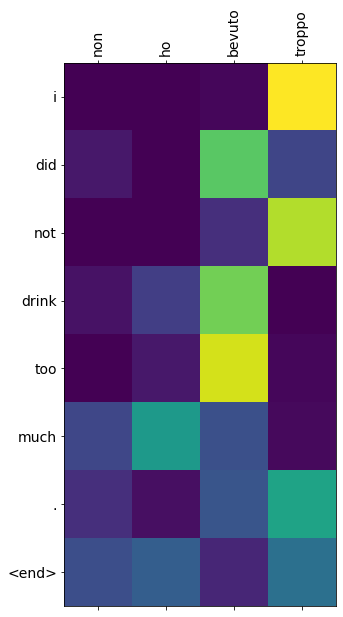

In [ ]:
plot_attention(all_attention_weights,  input_sent.split(' '), predicted_sentence.split(' '))

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
import nltk.translate.bleu_score as bleu
def calculate_bleu(model, tknizer_ita, tknizer_eng):
    bleu_scores = []
    thousand_samples = data.sample(1000)
    thousand_samples = thousand_samples[['italian','english_out']]
    for input_sent, reference in thousand_samples.values:
        pred_tokens, predicted_sentence, all_attention_weights = predict(input_sent, model, tknizer_ita, tknizer_eng)
        reference = reference.split() # the original, from the dataframe
        translation = predicted_sentence.split() # traslated using model
        bleu_scores.append(bleu.sentence_bleu(reference, translation))
    avg_bleu_score = np.mean(bleu_scores)
    return avg_bleu_score

In [ ]:
print("Avg Bleu Score 'Dot'=",calculate_bleu(model_attention, tknizer_ita, tknizer_eng))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Avg Bleu Score 'Dot'= 0.6302854734438311


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
from tensorflow.keras.callbacks import Callback
import datetime
%load_ext tensorboard

log_dir="/content/drive/My Drive/Colab Notebooks/NLP Attention Mechanism/logs/general/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model_attention_gen = encoder_decoder(vocab_size_ita, vocab_size_eng, encoder_inputs_length=20, decoder_inputs_length=20, embedding_dim=100, score_fun='general', att_units=256)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_attention_gen.compile(optimizer=opt, loss=loss_function)
train_steps=train.shape[0]//GLOBAL_BATCH_SIZE
valid_steps=validation.shape[0]//GLOBAL_BATCH_SIZE
model_attention_gen.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=valid_steps, callbacks=[tensorboard_callback])
model_attention_gen.summary()

#save_model_path = "/content/drive/My Drive/Colab Notebooks/NLP Attention Mechanism/New Attention Mech/Model_Best_Dot/BEST_MODEL_ED"
#model_attention_gen.save_weights(save_model_path, save_format='tf')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
  1/266 [..............................] - ETA: 0s - loss: 3.7379WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
266/266 [==============================] - 226s 851ms/step - loss: 1.5086 - val_loss: 1.0848
Epoch 2/10
266/266 [==============================] - 225s 845ms/step - loss: 0.8020 - val_loss: 0.5145
Epoch 3/10
266/266 [==============================] - 224s 843ms/step - loss: 0.4074 - val_loss: 0.2748
Epoch 4/10
266/266 [==============================] - 226s 850ms/step - loss: 0.2539 - val_loss: 0.1899
Epoch 5/10
266/266 [==============================] - 226s 848ms/step - loss: 0.1851 - val_loss: 0.1398
Epoch 6/10
266/266 [==============================] - 224s 842ms/step - loss: 0.1457 - val_loss: 0.1164
Epoch 7/10
266/266 [=============

In [ ]:
input_sent = "non ho bevuto troppo"
pred_tokens, predicted_sentence, all_attention_weights = predict(input_sent, model_attention_gen, tknizer_ita, tknizer_eng)
print(predicted_sentence)

i did not drink too much . <end> 


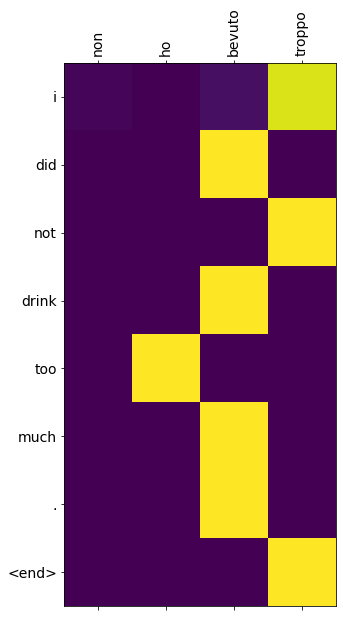

In [ ]:
plot_attention(all_attention_weights,  input_sent.split(' '), predicted_sentence.split(' '))

In [ ]:
!zip -r logs.zip logs

In [ ]:
print("Avg Bleu Score 'General'=",calculate_bleu(model_attention_gen, tknizer_ita, tknizer_eng))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Avg Bleu Score 'General'= 0.6367642238033103


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
from tensorflow.keras.callbacks import Callback
import datetime
%load_ext tensorboard

log_dir="/content/drive/My Drive/Colab Notebooks/NLP Attention Mechanism/logs/concat/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_grads=True)

In [ ]:
# Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model_attention_concat = encoder_decoder(vocab_size_ita, vocab_size_eng, encoder_inputs_length=20, decoder_inputs_length=20, embedding_dim=100, score_fun='concat', att_units=256)
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_attention_concat.compile(optimizer=opt, loss=loss_function)
train_steps=train.shape[0]//GLOBAL_BATCH_SIZE
valid_steps=validation.shape[0]//GLOBAL_BATCH_SIZE
model_attention_concat.fit(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=valid_steps, callbacks=[tensorboard_callback])
model_attention_concat.summary()

#save_model_path = "/content/drive/My Drive/Colab Notebooks/NLP Attention Mechanism/New Attention Mech/Model_Best_Concat/BEST_MODEL_ED"
#model_attention.save_weights(save_model_path, save_format='tf')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/10
  1/266 [..............................] - ETA: 0s - loss: 3.7388WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
266/266 [==============================] - 223s 840ms/step - loss: 1.5059 - val_loss: 1.0771
Epoch 2/10
266/266 [==============================] - 221s 831ms/step - loss: 0.8084 - val_loss: 0.5478
Epoch 3/10
266/266 [==============================] - 220s 826ms/step - loss: 0.4414 - val_loss: 0.3126
Epoch 4/10
266/266 [==============================] - 219s 824ms/step - loss: 0.2892 - val_loss: 0.2203
Epoch 5/10
266/266 [==============================] - 219s 821ms/step - loss: 0.2160 - val_loss: 0.1697
Epoch 6/10
266/266 [==============================] - 218s 820ms/step - loss: 0.1731 - val_loss: 0.1404
Epoch 7/10
266/266 [=============

In [ ]:
input_sent = "non ho bevuto troppo"
pred_tokens, predicted_sentence, all_attention_weights = predict(input_sent, model_attention_concat, tknizer_ita, tknizer_eng)
print(predicted_sentence)

i did not too drunk . <end> 


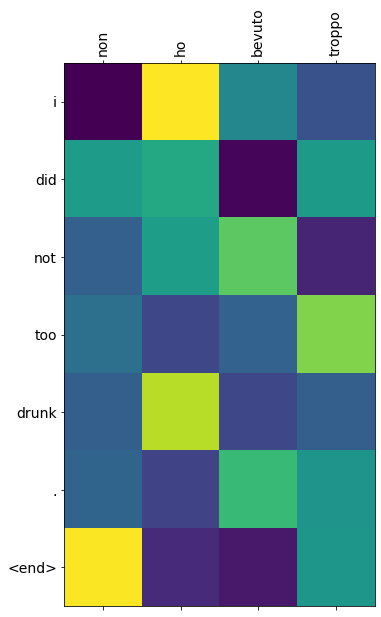

In [ ]:
plot_attention(all_attention_weights,  input_sent.split(' '), predicted_sentence.split(' '))

In [ ]:
print("Avg Bleu Score 'Concat'=",calculate_bleu(model_attention_concat, tknizer_ita, tknizer_eng))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Avg Bleu Score 'Concat'= 0.6070069372989185


### **<font color='purple'>Comparision of 3 models on Attention Mechanism</font>**

<ul>
<li>
Here, Bahdanau's attention mechanism is implemented. Three scoring function of attentions are implemented here. The following are the observations on each of the scoring functions.
    <ul>
        <li><b>dot: </b> This function needs same number of lstm units in the encoder and the decoder. The <b>loss is 0.0702 & Bleu score is 0.6303</b></li>
    </ul>
    <ul>
        <li><b>general: </b> This function can have different number of lstm units in the encoder and the decoder. We had to add a trainable weight matrix such that we can do a dot product on the encoder hidden states and the decoder hidden states. The <b>loss is 0.0708 & Bleu score is 0.6368</b></li>
    </ul>
    <ul>
        <li><b>concat: </b> This function can also have different number of lstm units in the encoder and the decoder. We had to add three trainable weight matrices, where one will be multiplied with the encoder hidden states, secong will be multiplied with the decoder hidden states and the third one will be multiplied after applying tanh on the addition of first two multiplications. The <b>loss is 0.0809 & Bleu score is 0.6070</b></li>
    </ul>
</li>
<li>Let's see what the attention plots of each scoring functions say.</li>
    <ul>
        <li><b>dot: </b> We can see that the dot function is focusing <b><i>bevuto</i></b> which means to drink, with the english words <b>did</b> and <b>drink</b></li>
    </ul>
    <ul>
        <li><b>general: </b> We can see that the general function is also giving us similar results, as it is focusing on <b><i>bevuto</i></b> which means to drink, with the english words <b>did</b> and <b>drink</b>. We can observe that this scoring function is sharply giving attention to fewer words and not spreading it across the predicted words.</li>
    </ul>
    <ul>
        <li><b>concat: </b> We can see that the concat function is focusing on <b><i>troppo</i></b> which means too much, with the english word <b>too</b>. The word <b><i>ho</i></b> which means 'I', is also giving attention on the english word <b>'I'</b> in the predicted sentence. We can observe that this scoring function is spreading it's attention to many words at a time, along with focusing more on the important words. However, we saw that this scoring function didn't predict the english word 'much'. This may be due to the spread of attention, that it couldn't give much attention to that word.</li>
    </ul>
</ul>
<b>PS: </b> All the three models are trained on 10 epochs, so that a fair comparision can be made on the losses, bleu scores and the predicted sentences.